# Deep Feature Consistent Variational Auto Encoder

[paper](https://arxiv.org/pdf/1610.00291.pdf)
[blog](https://github.com/krasserm/bayesian-machine-learning/blob/master/variational_autoencoder_dfc.ipynb)

#### Imports

In [51]:
import keras
from keras.models import load_model
from keras import backend as K
from keras import layers
from keras.models import Model, Sequential

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

#### Global variables

In [52]:
image_shape = (28, 28, 1)

latent_dim = 5
use_pretrained = True

In [53]:
pm = load_model('models/classifier.h5')

selected_pm_layers = ['conv2d_6', 'conv2d_7']
selected_pm_layer_weights = [1.0, 1.0]

#### Extra models

In [54]:
def create_predictor_linear(latent_dim):
    predictor_input = layers.Input(shape=(latent_dim,))
    
    x = layers.Dense(128, activation='relu')(predictor_input)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(1, activation='linear')(x)

    return Model(predictor_input, x, name='predictor')

In [55]:
def create_classifier(classes=10):
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=image_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(classes, activation='softmax'))
    return model

In [56]:
pm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                36928     
__________

#### Visualization

In [57]:
def plot_image_rows(images_list, title_list):
    rows = len(images_list)
    cols = len(images_list[0])
    
    def plot_image_row(images, title):
        plt.figure(figsize=(cols, 3))
        plt.gcf().suptitle(title)
        for i, img in enumerate(images):
            plt.subplot(rows, cols, i + 1)
            plt.imshow(img[:,:,0], cmap='Greys_r')
            plt.axis('off')

    for images, title in zip(images_list, title_list):
        plot_image_row(images, title)

def plot_laplacian_variances(lvs_1, lvs_2, lvs_3, title):
    plt.hist(lvs_1, alpha=0.2, bins=50, label='Original images');
    plt.hist(lvs_2, alpha=0.2, bins=50, label='Images generated by plain VAE');
    plt.hist(lvs_3, alpha=0.2, bins=50, label='Images generated by DFC VAE');
    plt.xlabel('Laplacian variance')
    plt.title(title)
    plt.legend();

#### Model

In [58]:
def create_encoder(latent_dim):
    encoder_iput = layers.Input(shape=image_shape, name='image')
    
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(encoder_iput)
    x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation='relu')(x)

    t_mean = layers.Dense(latent_dim, name='t_mean')(x)
    t_log_var = layers.Dense(latent_dim, name='t_log_var')(x)

    return Model(encoder_iput, [t_mean, t_log_var], name='encoder')

In [59]:
def create_decoder(latent_dim):
    decoder_input = layers.Input(shape=(latent_dim,), name='t')
    
    x = layers.Dense(12544, activation='relu')(decoder_input)
    x = layers.Reshape((14, 14, 64))(x)
    x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
    x = layers.Conv2D(1, 3, padding='same', activation='sigmoid', name='image')(x)
    
    return Model(decoder_input, x, name='decoder')


In [60]:
def sample(args):
    t_mean, t_log_var = args
    t_sigma = K.sqrt(K.exp(t_log_var))
    epsilon = K.random_normal(shape=K.shape(t_mean), mean=0., stddev=1.)
    return t_mean + t_sigma * epsilon

def create_sampler():
    return layers.Lambda(sample, name='sampler')

In [61]:
def create_vae(latent_dim, return_kl_loss_op=False):
    encoder = create_encoder(latent_dim)
    decoder = create_decoder(latent_dim)
    sampler = create_sampler()
    
    x = layers.Input(shape=(28, 28, 1), name='image')
    t_mean, t_log_var = encoder(x)
    t = sampler([t_mean, t_log_var])
    t_decoded = decoder(t)

    model = Model(x, t_decoded, name='vae')
    
    if return_kl_loss_op:
        kl_loss = -0.5 * K.sum(1 + t_log_var - K.square(t_mean) - K.exp(t_log_var), axis=-1)
        return model, kl_loss
    else:
        return model

#### Instances

In [62]:
# Create plain VAE model and associated KL divergence loss operation
vae, vae_kl_loss = create_vae(latent_dim, return_kl_loss_op=True)

# Create DFC VAE model and associated KL divergence loss operation
vae_dfc, vae_dfc_kl_loss = create_vae(latent_dim, return_kl_loss_op=True)

#### Loss functions

In [63]:
def vae_loss(x, t_decoded):
    return K.mean(reconstruction_loss(x, t_decoded) + vae_kl_loss)


def vae_dfc_loss(x, t_decoded):
    return K.mean(perceptual_loss(x, t_decoded) + vae_dfc_kl_loss)


def reconstruction_loss(x, t_decoded):
    return K.sum(K.binary_crossentropy(K.batch_flatten(x), K.batch_flatten(t_decoded)), axis=-1)


def perceptual_loss(x, t_decoded):
    outputs = [pm.get_layer(l).output for l in selected_pm_layers]
    model = Model(pm.input, outputs)

    h1_list = model(x)
    h2_list = model(t_decoded)
    
    rc_loss = 0.0
    
    for h1, h2, weight in zip(h1_list, h2_list, selected_pm_layer_weights):
        h1 = K.batch_flatten(h1)
        h2 = K.batch_flatten(h2)
        rc_loss = rc_loss + weight * K.sum(K.square(h1 - h2), axis=-1)
    
    return rc_loss

#### MNIST

In [64]:
from keras.datasets import mnist

In [65]:
def load_mnist_data(normalize=False, allowable=[]):
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    if allowable:
        train_mask = np.in1d(y_train, allowable)
        test_mask = np.in1d(y_test, allowable)
        
        x_train = x_train[train_mask]
        y_train = y_train[train_mask]
        
        x_test = x_test[test_mask]
        y_test = y_test[test_mask]

    x_train = x_train.reshape(x_train.shape + (1,))
    x_test = x_test.reshape(x_test.shape + (1,))

    if normalize:
        x_train = x_train.astype('float32') / 255.
        x_test = x_test.astype('float32') / 255.

    return (x_train, y_train), (x_test, y_test)

In [66]:
(x_train, _), (x_test, y_test) = load_mnist_data(normalize=True)

#### Train

In [67]:
if use_pretrained:
    vae.load_weights('models/vae_weights.h5')
else:
    vae.compile(optimizer='rmsprop', loss=vae_loss)
    vae.fit(x=x_train, y=x_train, epochs=15, shuffle=True, validation_data=(x_test, x_test), verbose=2)

In [68]:
if use_pretrained:
    vae_dfc.load_weights('models/vae_dfc_weights.h5')    
else:
    vae_dfc.compile(optimizer='rmsprop', loss=vae_dfc_loss)
    vae_dfc.fit(x=x_train, y=x_train, epochs=15, shuffle=True, validation_data=(x_test, x_test), verbose=2)

In [69]:
if not use_pretrained:
    vae.save_weights('models/vae_weights.h5')
    vae_dfc.save_weights('models/vae_dfc_weights.h5')

#### Experiments

In [70]:
def encode(model, images):
    return model.get_layer('encoder').predict(images)[0]

def decode(model, codes):
    return model.get_layer('decoder').predict(codes)

def encode_decode(model, images):
    return decode(model, encode(model, images))

In [86]:
selected_idx = [(y_test == i).nonzero()[0][800] for i in range(10)]
print(selected_idx)

[8243, 7048, 7683, 7983, 8121, 8878, 8446, 7903, 8147, 7813]


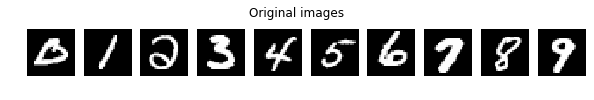

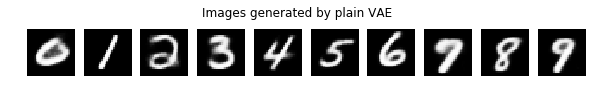

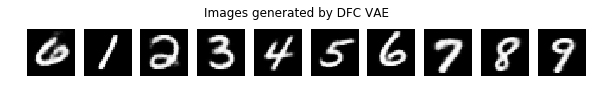

In [87]:
# if use_pretrained:
#     # Manually selected indices corresponding to digits 0-9 in the test set
#     selected_idx = [1203, 818, 892, 938, 902, 1131, 1162, 1012, 1120, 1063]
# else:
#     # Randomly selected indices 
#     selected_idx = np.random.choice(range(x_test.shape[0]), 10, replace=False)

selected = x_test[selected_idx]
selected_dec_vae = encode_decode(vae, selected)
selected_dec_vae_dfc = encode_decode(vae_dfc, selected)

plot_image_rows([selected, selected_dec_vae, selected_dec_vae_dfc], 
                ['Original images', 
                 'Images generated by plain VAE', 
                 'Images generated by DFC VAE'])

plt.show()

In [22]:
import cv2

def laplacian_variance(images):
    return [cv2.Laplacian(image, cv2.CV_32F).var() for image in images]

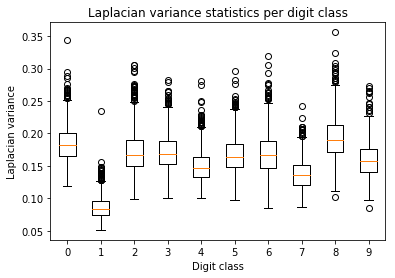

In [23]:
laplacian_variances = [laplacian_variance(x_test[y_test == i]) for i in range(10)]

plt.boxplot(laplacian_variances, labels=range(10));
plt.xlabel('Digit class')
plt.ylabel('Laplacian variance')
plt.title('Laplacian variance statistics per digit class');

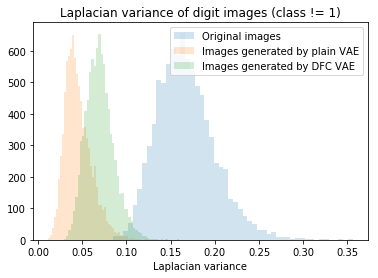

In [24]:
x_dec_vae = encode_decode(vae, x_test)
x_dec_vae_dfc = encode_decode(vae_dfc, x_test)

not_ones = y_test != 1

lvs_1 = laplacian_variance(x_test[not_ones])
lvs_2 = laplacian_variance(x_dec_vae[not_ones])
lvs_3 = laplacian_variance(x_dec_vae_dfc[not_ones])

plot_laplacian_variances(lvs_1, lvs_2, lvs_3, title='Laplacian variance of digit images (class != 1)')

#### Linear interpolation

In [25]:
def linear_interpolation(model, x_from, x_to, steps):
    n = steps + 1

    t_from = encode(model, np.array([x_from]))[0]
    t_to = encode(model, np.array([x_to]))[0]

    diff = t_to - t_from
    inter = np.zeros((n, t_from.shape[0]))
    for i in range(n):
        inter[i] = t_from + i / steps * diff

    return decode(model, inter)

def plot_linear_interpolations(x_from, x_to, steps=10):
    plot_image_rows([linear_interpolation(vae, x_from, x_to, steps), 
                     linear_interpolation(vae_dfc, x_from, x_to, steps)], 
                    ['Linear interpolation with plain VAE', 
                     'Linear interpolation with DFC VAE'])

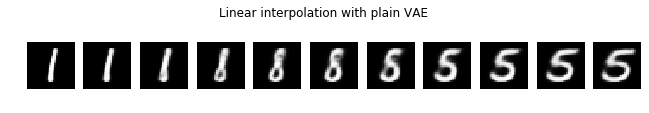

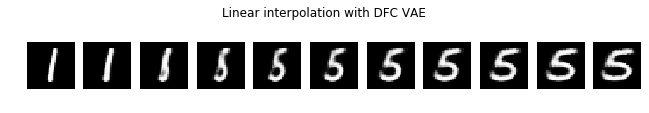

In [26]:
plot_linear_interpolations(selected[1], selected[5])

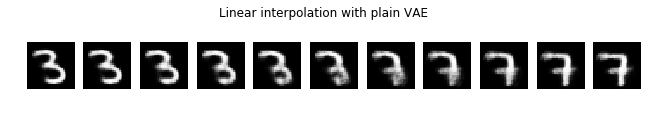

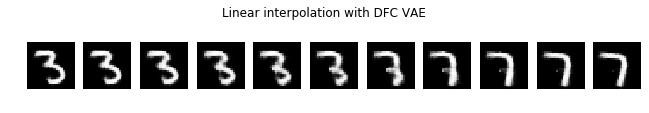

In [27]:
plot_linear_interpolations(selected[3], selected[7])

In [28]:
def variance(model, images):
    logvar = model.get_layer('encoder').predict(images)[1]
    return np.exp(logvar * 0.5)

In [29]:
vae.reset_states()
vae_dfc.reset_states()

use_pretrained = True

In [30]:
selected_pm_layers = ['conv2d_21', 'conv2d_22']
selected_pm_layer_weights = [1.0, 1.0]

if use_pretrained:
    pm = load_model('models/classifier_part.h5')
else:
    pm = create_classifier(classes=2)
    
    (x_train, y_train), (x_test, y_test) = load_mnist_data(normalize=True, allowable=[1, 3, 4, 7, 8, 9])
    
    y_train = np.in1d(y_train, [4, 7]) * 1.0
    y_test = np.in1d(y_test, [4, 7]) * 1.0

    y_train = keras.utils.to_categorical(y_train, 2)
    y_test = keras.utils.to_categorical(y_test, 2)
    
    opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
    pm.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    pm.fit(x=x_train, y=y_train, epochs=15, shuffle=True, validation_data=(x_test, y_test), verbose=2)

In [31]:
(x_train, _), (x_test, y_test) = load_mnist_data(normalize=True, allowable=[4, 7])

In [32]:
(_, _), (x_test2, _) = load_mnist_data(normalize=True, allowable=[5])

In [33]:
if use_pretrained:
    vae.load_weights('models/vae_weights_part.h5')
else:
    vae.compile(optimizer='rmsprop', loss=vae_loss)
    vae.fit(x=x_train, y=x_train, epochs=15, shuffle=True, validation_data=(x_test, x_test), verbose=2)

In [34]:
if use_pretrained:
    vae_dfc.load_weights('models/vae_dfc_weights_part.h5')    
else:
    vae_dfc.compile(optimizer='rmsprop', loss=vae_dfc_loss)
    vae_dfc.fit(x=x_train, y=x_train, epochs=15, shuffle=True, validation_data=(x_test, x_test), verbose=2)

In [35]:
if not use_pretrained:
    vae.save_weights('models/vae_weights_part.h5')
    vae_dfc.save_weights('models/vae_dfc_weights_part.h5')
    pm.save('models/classifier_part.h5')

In [36]:
def compare_variances(model, a, b, label1='first', label2='second'):
    std1 = variance(model, a).sum(axis=1)
    std2 = variance(model, b).sum(axis=1)
    
    plt.figure(figsize=(12, 4))
    plt.title('Variance compare')
    
    plt.axvline(std1.mean(), color='blue')
    plt.axvline(std2.mean(), color='orange')
    
    plt.hist(std1, bins=100, alpha=0.85, label=label1)
    plt.hist(std2, bins=100, alpha=0.85, label=label2)
    
    plt.legend()
    plt.show()

In [37]:
def compare_reconstruction_loss(model, a, b, label1='first', label2='second'):
    reco_a = encode_decode(model, a)
    reco_b = encode_decode(model, b)
    
    loss1 = ((a.reshape(-1, 28 * 28) - reco_a.reshape(-1, 28 * 28))**2).sum(axis=1)
    loss2 = ((b.reshape(-1, 28 * 28) - reco_b.reshape(-1, 28 * 28))**2).sum(axis=1)
    
    plt.figure(figsize=(12, 4))
    plt.title('Reconstruction loss compare')
    
    plt.axvline(loss1.mean(), color='blue')
    plt.axvline(loss2.mean(), color='orange')
    
    plt.hist(loss1, bins=100, alpha=0.85, label=label1)
    plt.hist(loss2, bins=100, alpha=0.85, label=label2)
    
    plt.legend()
    plt.show()

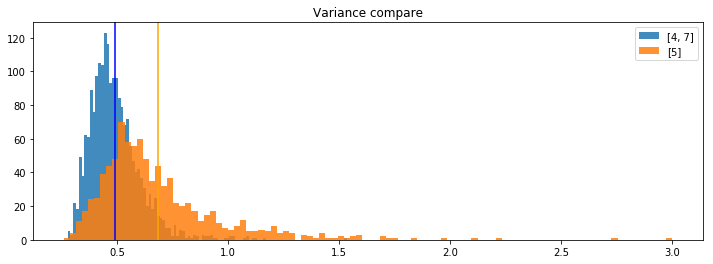

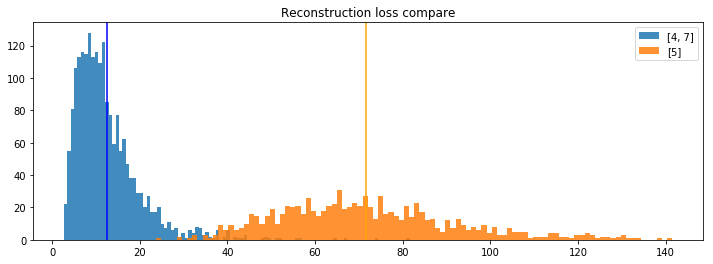

In [38]:
compare_variances(vae, x_test, x_test2, '[4, 7]', '[5]')
compare_reconstruction_loss(vae, x_test, x_test2, '[4, 7]', '[5]')

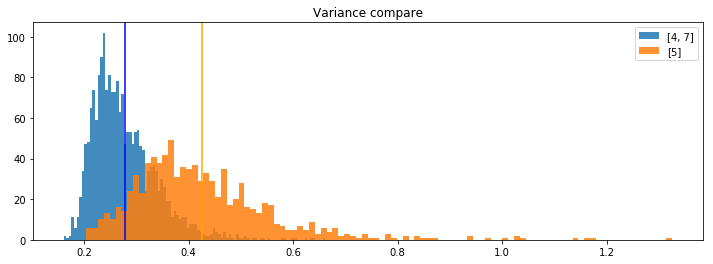

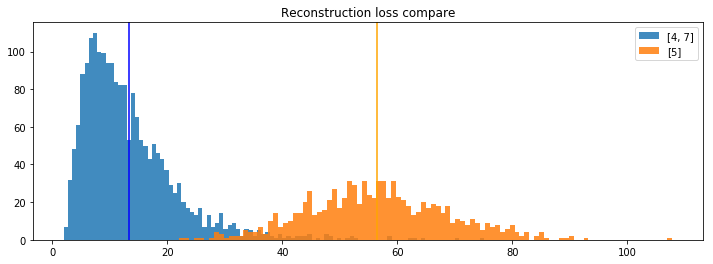

In [39]:
compare_variances(vae_dfc, x_test, x_test2, '[4, 7]', '[5]')
compare_reconstruction_loss(vae_dfc, x_test, x_test2, '[4, 7]', '[5]')

In [48]:
def kld(model, images):
    mu, logvar = model.get_layer('encoder').predict(images)
    return (-0.5 * (1 + logvar - np.power(mu, 2) - np.exp(logvar))).mean(1)

In [42]:
outputs = [pm.get_layer(l).output for l in selected_pm_layers]
model = Model(pm.input, outputs)

In [ ]:
for l in selected_pm_layers:
    h = pm.get_layer(l).predict(x_test[:10])

In [49]:
def compare(model, a, b, label1='first', label2='second'):

    reco_a = encode_decode(model, a)
    reco_b = encode_decode(model, b)
    
#     loss1 = ((a.reshape(-1, 28 * 28) - reco_a.reshape(-1, 28 * 28))**2).sum(axis=1)
#     loss2 = ((b.reshape(-1, 28 * 28) - reco_b.reshape(-1, 28 * 28))**2).sum(axis=1)

    loss1 = K.eval(perceptual_loss(K.variable(a), K.variable(reco_a)))
    loss2 = K.eval(perceptual_loss(K.variable(b), K.variable(reco_b)))

#     std1 = variance(model, a).sum(axis=1)
#     std2 = variance(model, b).sum(axis=1)

    kld1 = kld(model, a)
    kld2 = kld(model, b)

    fig = plt.figure(figsize=(15, 6))
    gs = gridspec.GridSpec(4, 5)

    ax_main = plt.subplot(gs[1:3, :4])
    ax_xDist = plt.subplot(gs[0, :4], sharex=ax_main)
    ax_yDist = plt.subplot(gs[1:3, 4], sharey=ax_main)

    for (x, y), label in [((loss1, kld1), label1), ((loss2, kld2), label2)]:
        ax_main.scatter(x, y, s=3, alpha=0.7, label=label)
        ax_xDist.hist(x, bins=100, histtype='step')
        ax_yDist.hist(y, bins=100, orientation='horizontal', histtype='step')

    ax_main.set(xlabel="Perceptual Loss", ylabel="KLD", title=f'Compare losses for labeled images')
    ax_main.legend()

    plt.tight_layout()
    plt.show()

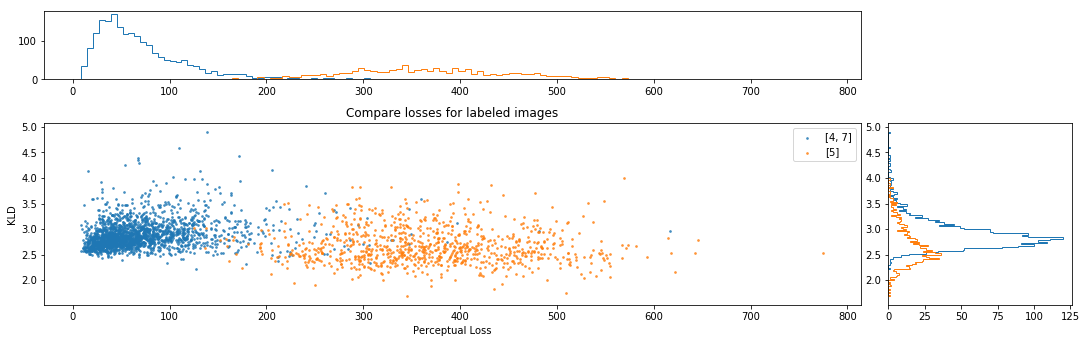

In [50]:
compare(vae_dfc, x_test, x_test2, '[4, 7]', '[5]')

In [ ]:
# compare(vae, x_test, x_test2, '[4, 7]', '[5]')